In [1]:
# !pip install medmnist --quiet
# !python -m medmnist download
# !python -m medmnist save --flag=breastmnist --folder=./breastmnist/ --postfix=png 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers,optimizers,losses, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Read Data

In [3]:
import os
import shutil

path = "breastmnist"
# def split_data(path):
df = pd.read_csv(os.path.join(path,'breastmnist.csv'),header=None)
df = df.rename(columns={0:'type',1:'name',2:"class"})

for group, rows in df.groupby(['type','class']):
    if not os.path.isdir(os.path.join(path,group[0])):
        os.mkdir(os.path.join(path,group[0]))
    if not os.path.isdir(os.path.join(path,group[0],str(group[1]))):
        os.mkdir(os.path.join(path,group[0],str(group[1])))
    for row in rows.iterrows():
        shutil.copy(os.path.join(path,'breastmnist',row[1]['name']),os.path.join(path,group[0],str(group[1]),row[1]['name']))

In [4]:
batch_size=256 
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory("breastmnist/TRAIN", class_mode='categorical',batch_size=batch_size, target_size=(28,28),shuffle=True)
valid_generator = val_datagen.flow_from_directory("breastmnist/VALIDATION", class_mode='categorical',batch_size=batch_size, target_size=(28,28),shuffle=True)
test_generator = test_datagen.flow_from_directory("breastmnist/TEST", class_mode='categorical',batch_size=batch_size, target_size=(28,28),shuffle=True)



Found 546 images belonging to 2 classes.
Found 78 images belonging to 2 classes.
Found 156 images belonging to 2 classes.


# Model RESNET50

In [5]:
resnet50_base_model = keras.applications.resnet50.ResNet50( weights = 'imagenet',include_top = False, pooling = 'avg',)
resnet50_base_model.trainable = False

In [6]:
resnet_model = Sequential()
resnet_model.add(resnet50_base_model)
resnet_model.add(layers.Dense(20,activation = 'relu'))
resnet_model.add(layers.Dense(2,activation = 'softmax'))
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
 dense_1 (Dense)             (None, 2)                 42        
                                                                 
Total params: 23,628,734
Trainable params: 41,022
Non-trainable params: 23,587,712
_________________________________________________________________


In [7]:
resnet_model.compile(optimizer=optimizers.legacy.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = resnet_model.fit(train_generator,epochs=25,validation_data=valid_generator)


Epoch 1/25


2023-06-30 18:27:52.003175: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 3s 594ms/step - loss: 1.2035 - accuracy: 0.6502 - val_loss: 0.8606 - val_accuracy: 0.7692
Epoch 2/25
3/3 [==============================] - 0s 95ms/step - loss: 0.7557 - accuracy: 0.7692 - val_loss: 0.6594 - val_accuracy: 0.8205
Epoch 3/25
3/3 [==============================] - 0s 95ms/step - loss: 0.6591 - accuracy: 0.7418 - val_loss: 0.5497 - val_accuracy: 0.6923
Epoch 4/25
3/3 [==============================] - 0s 105ms/step - loss: 0.6435 - accuracy: 0.7326 - val_loss: 0.6065 - val_accuracy: 0.8462
Epoch 5/25
3/3 [==============================] - 0s 96ms/step - loss: 0.5728 - accuracy: 0.8022 - val_loss: 0.6562 - val_accuracy: 0.8333
Epoch 6/25
3/3 [==============================] - 0s 96ms/step - loss: 0.5058 - accuracy: 0.8242 - val_loss: 0.5194 - val_accuracy: 0.8205
Epoch 7/25
3/3 [==============================] - 0s 99ms/step - loss: 0.4413 - accuracy: 0.8040 - val_loss: 0.5056 - val_accuracy: 0.8333
Epoch 8/25
3/3 [====================

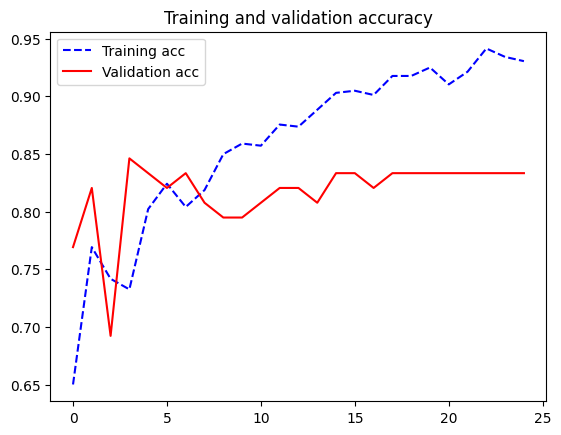

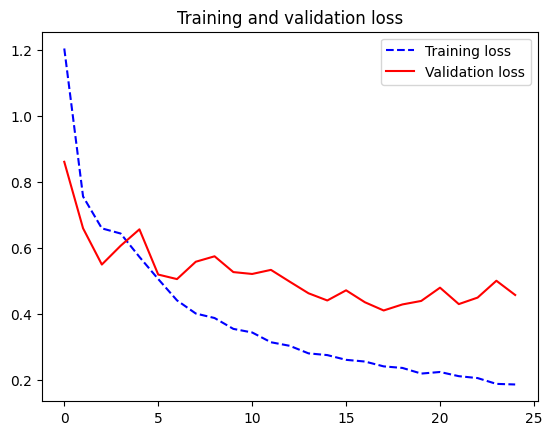

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("loss.png")
plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("acc.png")

In [9]:
from sklearn.metrics import confusion_matrix,classification_report

y_pred = resnet_model.predict(test_generator)
y_pred = y_pred.argmax(axis=1)
print("confusion_matrix\n",confusion_matrix(test_generator.labels,y_pred))
print(classification_report(test_generator.labels,y_pred))

1/1 [==============================] - 1s 695ms/step
confusion_matrix
 [[11 31]
 [24 90]]
              precision    recall  f1-score   support

           0       0.31      0.26      0.29        42
           1       0.74      0.79      0.77       114

    accuracy                           0.65       156
   macro avg       0.53      0.53      0.53       156
weighted avg       0.63      0.65      0.64       156



# Conditional DCGAN

In [10]:
batch_size=256 
train_datagen=ImageDataGenerator(rescale=1/255.)
val_datagen=ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_directory("breastmnist/TRAIN", class_mode='categorical',batch_size=batch_size, target_size=(28,28),shuffle=True,color_mode="grayscale")
valid_generator = val_datagen.flow_from_directory("breastmnist/VALIDATION", class_mode='categorical',batch_size=batch_size, target_size=(28,28),shuffle=True,)


Found 546 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [11]:
"""We create Generator which uses MLP using simple dense layers activated by tanh"""
def create_generator():
    generator=Sequential()
    generator.add(layers.InputLayer(input_shape=(16*16,)))
    generator.add(layers.Dense(units=16*16))
    generator.add(layers.Reshape((16, 16, 1)))
    generator.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    generator.add(layers.Conv2DTranspose(20,(5,5)))
    generator.add(layers.LeakyReLU(0.2))
    generator.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    generator.add(layers.Conv2DTranspose(20,(5,5)))
    generator.add(layers.LeakyReLU(0.2))
    generator.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    generator.add(layers.Conv2DTranspose(20,(5,5)))
    generator.add(layers.LeakyReLU(0.2))
    generator.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    generator.add(layers.Conv2D(1,(5,5),activation='sigmoid',padding='same'))
    generator.add(layers.Flatten())
    return generator
g=create_generator()
g.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 20)       520       
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20, 20, 20)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 20)      

In [12]:

"""We now create the Discriminator which is also MLP. Discriminator will take the input from real data which is of the size 784 and also the images generated from Generator."""

def create_discriminator(input_shape):
    discriminator=Sequential()
    discriminator.add(layers.InputLayer(input_shape=input_shape))
    discriminator.add(layers.Reshape((28, 28, 1)))
    
    discriminator.add(layers.Conv2D(32,(5,5)))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))
       
    discriminator.add(layers.Conv2D(64,(5,5)))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))
    
    discriminator.add(layers.Conv2D(256,(5,5)))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))
    
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(units=1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.legacy.Adam())

    return discriminator

d =create_discriminator((28*28*1,))
d.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)       

In [13]:
def create_gan(discriminator, generator,input_shape):
    discriminator.trainable=False
    gan_input = layers.Input(shape=input_shape)
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizers.legacy.SGD())
    return gan

input_shape = train_generator[0]
gan = create_gan(d,g,(16*16,))
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 784)               87097     
                                                                 
 sequential_2 (Sequential)   (None, 1)                 527489    
                                                                 
Total params: 614,586
Trainable params: 86,975
Non-trainable params: 527,611
_________________________________________________________________


In [14]:
def plot_generated_images(epoch, generator, examples=3*3, dim=(3,3), figsize=(3,3)):
    noise= np.random.normal(0,1, [examples, 16*16-2])
    noise_class = np.random.randint(0,2,[examples,1])
    noise_class_one_hot = np.zeros((examples, 2))
    noise_class_one_hot[np.arange(examples), noise_class] = 1
    input_nois = np.hstack([noise,noise_class_one_hot])
    generated_images = generator.predict(input_nois,verbose=0)
    generated_images = generated_images.reshape(examples,28,28,-1)*255
    generated_images = np.asarray(generated_images,dtype=np.uint8)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.suptitle('Generated images after {} epochs'.format(str(epoch)), y=0.995)
    plt.tight_layout()    
    plt.savefig('gan_generated_image %d.png' %epoch)
    plt.show()


global epoch is 0


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


global epoch is 1


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 2


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 3


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 4


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 5


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 6


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 7


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 8


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 9


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 10


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 11


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 12


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 13


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 14


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 15


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 16


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 17


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 18


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 19


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


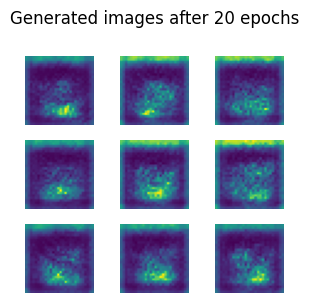

global epoch is 20


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 21


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 22


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 23


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 24


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


global epoch is 25


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 26


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 27


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 28


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


global epoch is 29


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 30


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 31


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 32


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 33


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 34


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 35


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 36


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 37


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 38


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 39


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


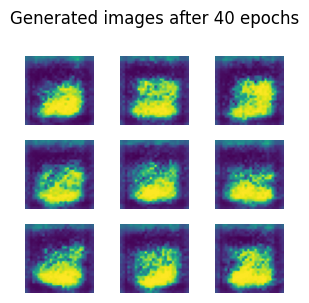

global epoch is 40


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 41


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 42


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 43


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 44


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 45


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 46


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 47


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 48


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 49


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 50


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 51


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 52


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 53


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 54


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.86it/s]


global epoch is 55


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


global epoch is 56


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 57


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 58


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


global epoch is 59


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


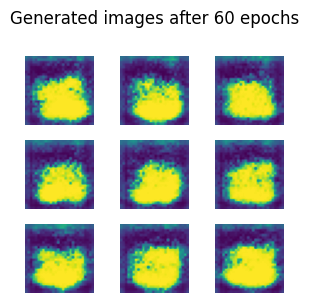

global epoch is 60


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 61


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 62


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 63


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 64


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


global epoch is 65


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 66


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 67


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


global epoch is 68


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 69


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 70


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 71


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 72


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 73


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 74


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 75


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 76


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 77


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 78


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 79


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


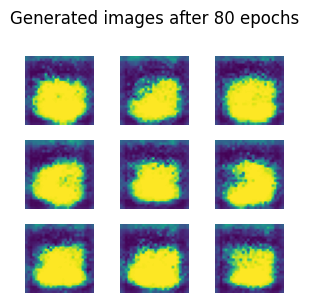

global epoch is 80


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 81


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 82


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 83


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 84


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 85


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 86


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 87


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 88


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 89


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 90


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 91


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 92


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 93


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 94


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 95


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 96


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 97


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 98


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 99


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


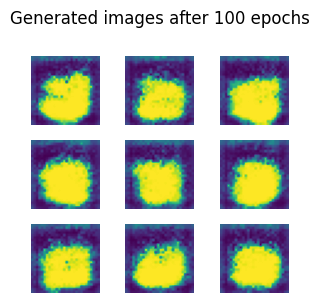

global epoch is 100


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


global epoch is 101


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 102


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 103


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 104


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 105


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 106


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 107


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 108


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 109


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 110


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 111


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 112


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 113


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 114


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 115


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 116


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 117


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 118


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 119


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


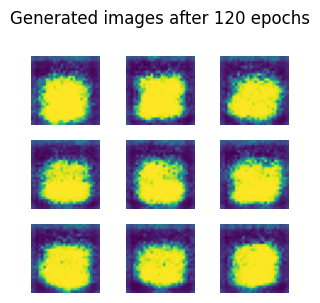

global epoch is 120


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 121


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 122


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 123


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 124


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 125


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 126


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 127


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 128


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 129


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 130


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 131


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 132


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 133


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 134


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 135


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 136


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 137


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 138


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 139


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


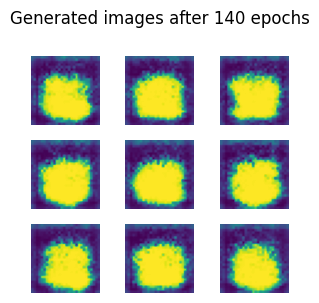

global epoch is 140


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 141


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 142


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 143


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 144


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 145


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 146


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 147


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 148


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 149


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 150


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 151


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 152


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 153


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 154


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 155


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 156


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 157


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 158


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 159


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


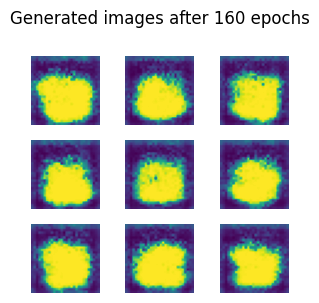

global epoch is 160


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 161


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 162


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 163


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 164


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 165


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 166


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 167


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 168


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 169


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 170


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 171


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 172


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 173


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 174


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 175


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 176


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 177


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 178


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 179


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


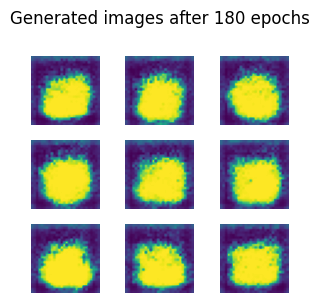

global epoch is 180


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 181


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 182


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 183


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 184


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 185


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 186


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 187


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 188


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 189


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 190


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 191


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 192


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 193


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 194


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 195


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 196


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 197


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 198


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 199


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


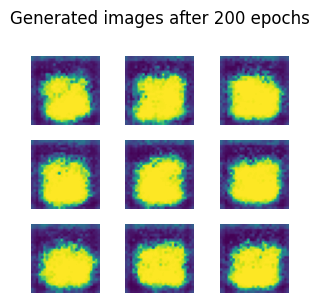

global epoch is 200


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 201


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 202


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 203


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 204


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 205


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 206


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 207


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 208


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 209


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 210


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 211


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 212


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 213


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 214


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


global epoch is 215


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 216


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 217


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 218


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 219


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


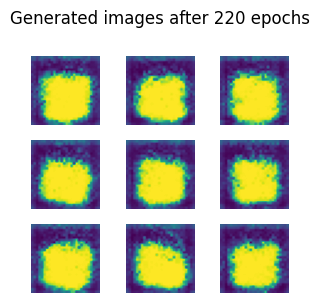

global epoch is 220


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 221


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 222


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 223


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 224


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 225


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 226


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 227


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 228


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 229


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 230


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 231


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 232


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 233


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 234


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 235


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 236


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 237


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 238


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


global epoch is 239


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


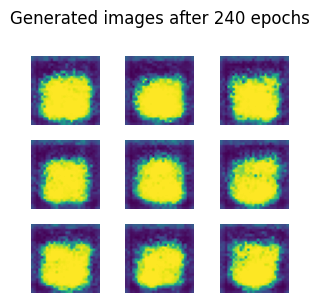

global epoch is 240


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 241


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 242


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 243


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 244


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 245


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 246


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 247


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 248


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 249


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 250


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 251


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 252


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 253


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 254


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 255


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 256


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 257


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


global epoch is 258


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 259


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


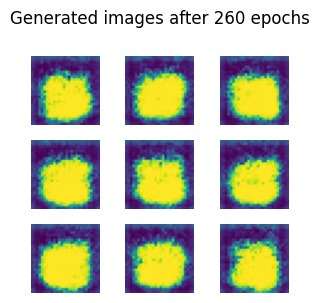

global epoch is 260


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 261


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 262


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 263


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 264


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 265


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


global epoch is 266


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 267


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 268


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 269


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 270


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 271


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


global epoch is 272


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 273


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 274


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 275


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 276


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 277


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 278


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 279


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


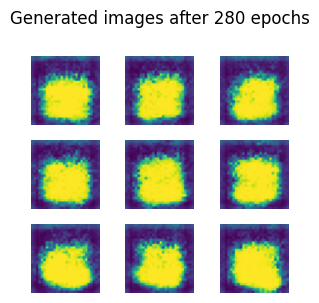

global epoch is 280


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 281


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 282


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 283


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 284


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


global epoch is 285


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 286


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 287


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 288


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 289


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


global epoch is 290


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 291


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 292


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 293


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 294


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 295


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 296


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 297


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 298


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 299


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


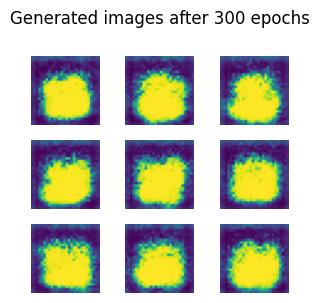

global epoch is 300


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 301


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 302


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 303


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


global epoch is 304


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 305


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 306


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 307


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 308


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 309


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 310


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 311


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 312


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 313


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 314


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 315


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 316


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 317


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 318


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 319


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


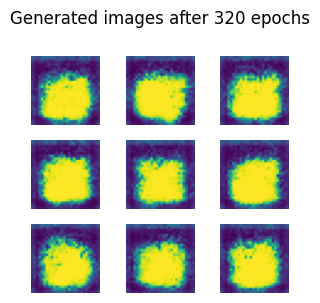

global epoch is 320


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 321


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 322


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.93it/s]


global epoch is 323


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 324


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 325


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 326


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 327


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 328


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 329


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 330


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 331


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 332


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 333


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 334


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


global epoch is 335


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 336


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 337


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 338


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 339


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


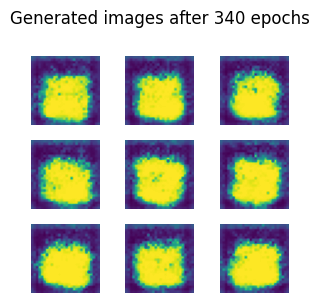

global epoch is 340


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 341


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.94it/s]


global epoch is 342


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 343


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 344


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 345


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 346


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 347


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 348


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 349


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 350


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 351


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 352


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 353


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 354


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 355


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 356


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 357


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 358


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 359


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


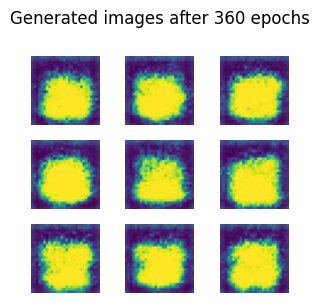

global epoch is 360


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 361


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 362


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 363


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


global epoch is 364


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 365


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 366


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 367


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 368


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 369


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 370


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 371


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 372


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 373


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 374


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 375


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 376


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 377


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 378


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 379


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


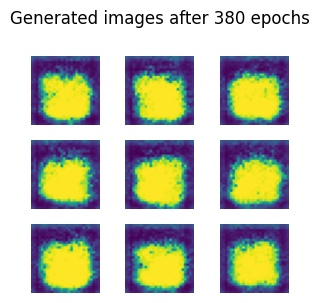

global epoch is 380


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 381


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 382


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 383


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 384


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 385


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 386


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 387


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 388


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 389


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 390


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 391


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


global epoch is 392


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 393


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 394


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 395


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 396


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 397


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 398


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 399


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


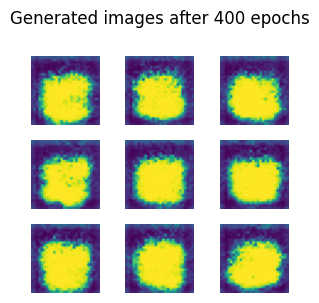

global epoch is 400


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


global epoch is 401


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 402


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 403


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 404


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 405


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 406


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 407


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 408


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 409


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 410


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 411


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 412


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 413


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 414


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 415


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 416


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 417


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 418


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 419


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


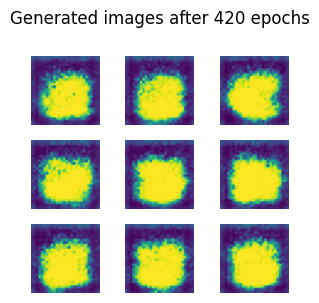

global epoch is 420


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 421


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 422


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 423


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 424


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 425


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 426


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 427


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 428


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 429


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 430


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 431


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 432


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 433


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 434


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


global epoch is 435


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 436


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 437


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 438


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 439


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


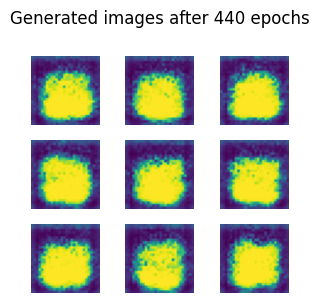

global epoch is 440


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 441


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 442


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 443


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 444


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 445


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 446


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 447


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 448


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 449


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 450


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 451


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 452


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 453


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 454


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 455


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 456


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 457


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 458


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 459


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


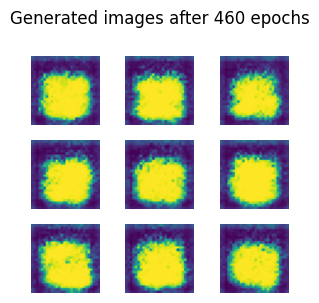

global epoch is 460


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 461


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 462


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 463


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 464


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 465


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 466


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 467


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 468


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 469


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 470


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 471


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 472


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 473


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


global epoch is 474


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 475


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 476


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 477


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 478


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 479


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


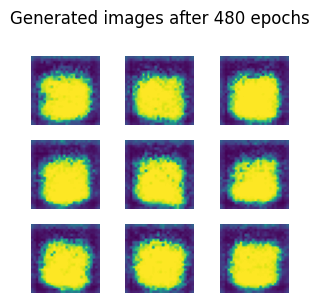

global epoch is 480


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 481


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 482


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 483


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 484


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 485


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 486


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 487


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 488


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 489


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 490


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 491


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 492


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 493


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 494


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.88it/s]


global epoch is 495


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 496


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 497


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 498


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 499


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


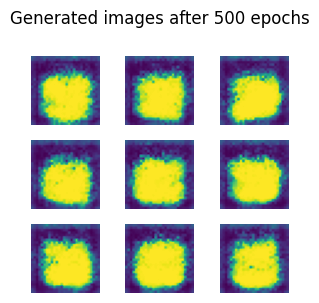

global epoch is 500


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


global epoch is 501


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 502


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 503


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 504


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 505


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 506


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 507


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 508


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 509


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 510


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 511


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 512


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 513


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


global epoch is 514


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 515


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 516


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 517


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 518


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 519


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


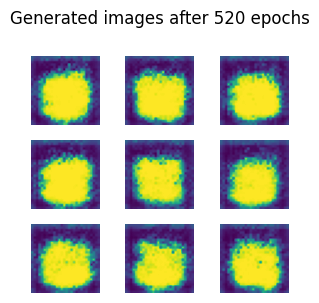

global epoch is 520


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 521


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 522


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


global epoch is 523


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 524


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 525


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 526


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 527


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 528


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


global epoch is 529


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 530


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 531


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 532


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 533


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 534


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 535


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 536


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 537


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 538


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 539


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


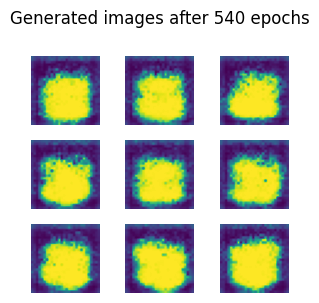

global epoch is 540


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 541


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 542


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 543


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 544


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 545


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 546


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 547


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 548


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 549


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 550


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 551


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.88it/s]


global epoch is 552


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 553


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 554


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 555


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 556


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 557


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


global epoch is 558


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 559


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


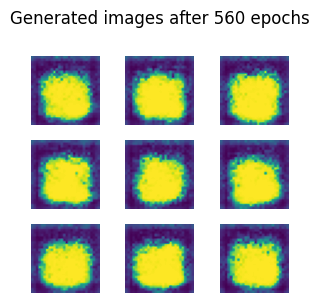

global epoch is 560


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 561


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


global epoch is 562


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 563


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 564


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 565


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 566


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


global epoch is 567


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 568


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 569


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 570


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 571


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 572


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 573


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 574


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 575


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 576


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 577


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 578


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 579


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


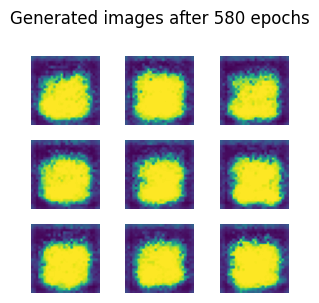

global epoch is 580


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 581


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 582


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 583


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 584


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 585


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 586


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 587


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 588


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 589


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 590


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 591


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 592


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 593


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 594


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 595


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 596


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 597


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 598


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 599


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


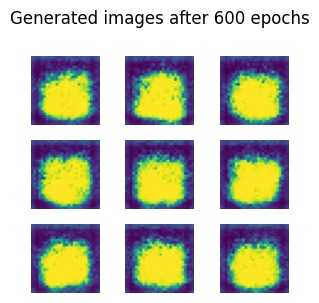

global epoch is 600


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 601


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 602


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 603


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 604


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 605


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 606


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 607


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 608


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 609


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 610


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 611


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 612


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 613


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 614


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 615


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 616


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 617


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 618


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 619


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


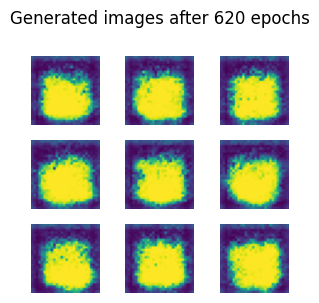

global epoch is 620


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


global epoch is 621


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 622


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 623


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 624


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 625


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 626


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 627


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 628


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 629


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


global epoch is 630


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 631


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 632


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 633


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 634


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 635


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 636


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 637


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


global epoch is 638


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.85it/s]


global epoch is 639


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


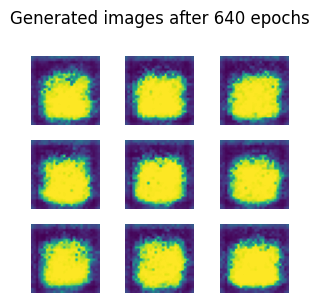

global epoch is 640


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 641


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 642


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 643


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 644


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 645


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 646


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 647


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


global epoch is 648


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 649


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 650


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 651


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 652


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 653


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 654


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 655


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 656


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 657


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 658


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 659


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


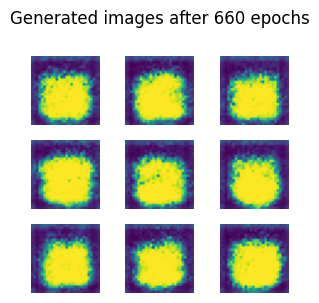

global epoch is 660


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 661


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 662


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


global epoch is 663


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 664


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


global epoch is 665


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 666


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 667


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 668


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 669


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


global epoch is 670


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 671


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 672


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


global epoch is 673


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 674


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 675


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 676


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 677


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 678


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 679


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


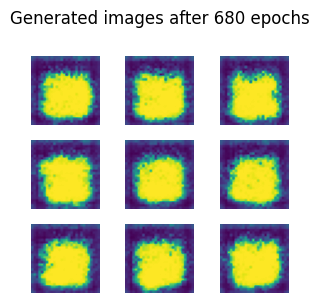

global epoch is 680


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 681


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 682


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 683


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 684


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 685


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 686


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 687


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 688


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 689


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 690


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 691


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 692


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 693


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


global epoch is 694


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 695


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


global epoch is 696


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 697


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 698


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


global epoch is 699


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


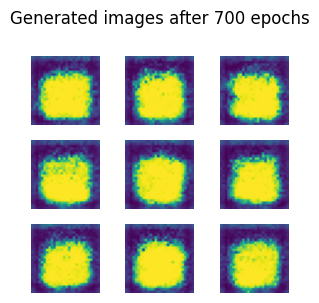

global epoch is 700


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


global epoch is 701


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 702


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 703


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 704


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 705


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


global epoch is 706


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 707


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 708


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


global epoch is 709


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 710


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


global epoch is 711


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


global epoch is 712


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 713


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 714


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


global epoch is 715


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 716


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 717


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 718


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 719


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


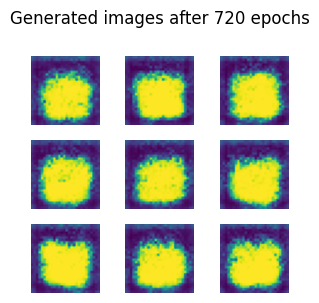

global epoch is 720


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 721


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 722


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 723


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 724


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


global epoch is 725


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


global epoch is 726


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 727


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


global epoch is 728


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 729


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 730


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 731


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 732


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 733


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 734


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 735


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 736


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 737


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 738


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 739


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


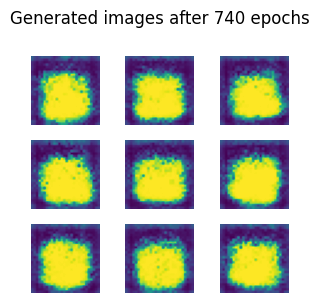

global epoch is 740


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 741


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 742


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 743


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.90it/s]


global epoch is 744


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 745


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 746


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 747


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 748


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 749


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 750


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 751


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


global epoch is 752


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


global epoch is 753


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


global epoch is 754


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


global epoch is 755


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 756


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 757


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 758


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 759


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


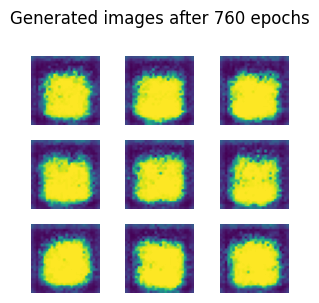

global epoch is 760


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


global epoch is 761


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 762


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 763


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 764


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 765


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 766


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 767


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 768


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 769


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 770


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 771


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 772


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


global epoch is 773


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 774


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 775


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 776


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 777


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 778


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 779


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


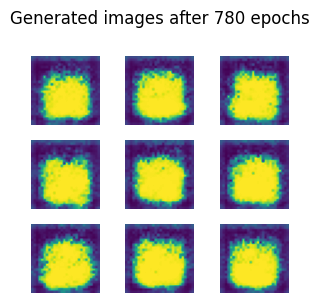

global epoch is 780


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 781


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 782


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 783


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 784


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 785


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 786


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 787


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 788


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 789


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 790


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 791


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 792


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 793


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 794


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


global epoch is 795


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 796


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 797


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 798


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 799


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


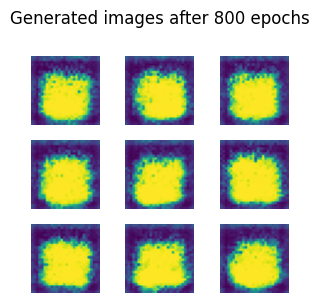

global epoch is 800


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 801


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


global epoch is 802


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 803


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 804


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 805


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 806


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 807


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 808


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 809


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 810


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 811


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 812


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 813


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 814


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 815


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 816


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 817


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 818


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 819


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


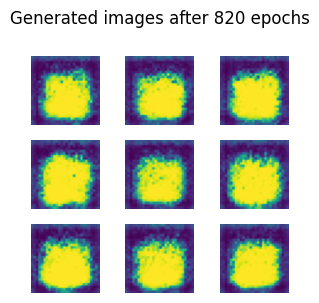

global epoch is 820


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 821


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 822


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 823


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 824


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 825


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 826


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 827


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 828


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 829


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 830


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 831


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 832


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 833


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 834


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 835


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 836


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 837


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 838


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 839


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


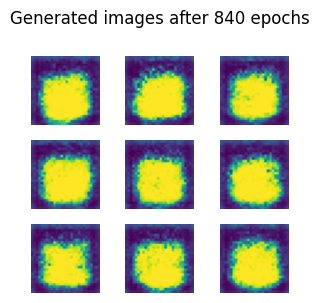

global epoch is 840


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 841


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 842


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 843


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 844


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 845


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 846


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 847


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 848


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 849


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 850


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 851


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 852


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


global epoch is 853


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 854


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 855


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 856


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 857


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 858


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 859


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


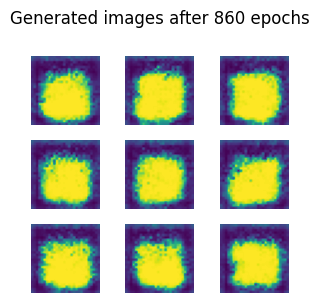

global epoch is 860


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 861


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 862


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 863


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 864


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 865


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 866


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 867


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


global epoch is 868


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 869


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 870


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 871


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 872


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 873


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 874


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 875


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 876


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 877


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 878


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 879


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


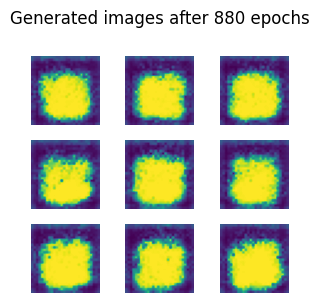

global epoch is 880


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 881


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 882


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 883


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 884


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 885


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 886


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 887


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 888


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 889


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 890


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 891


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 892


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 893


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 894


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 895


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 896


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 897


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 898


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 899


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


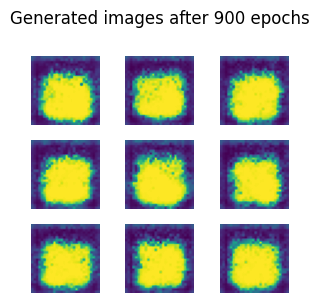

global epoch is 900


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 901


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 902


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 903


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 904


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 905


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 906


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


global epoch is 907


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 908


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 909


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


global epoch is 910


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 911


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 912


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 913


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 914


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 915


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 916


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 917


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


global epoch is 918


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 919


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


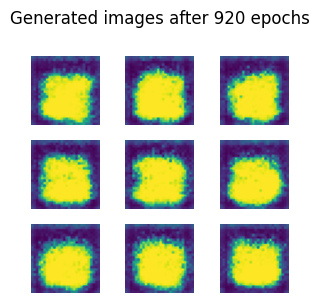

global epoch is 920


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


global epoch is 921


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 922


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


global epoch is 923


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


global epoch is 924


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 925


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 926


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 927


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 928


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


global epoch is 929


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 930


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 931


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 932


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 933


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 934


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 935


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


global epoch is 936


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 937


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 938


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 939


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


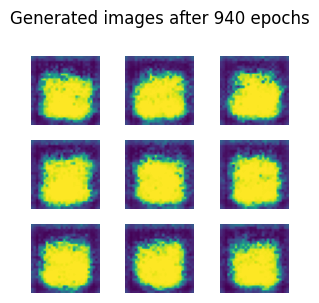

global epoch is 940


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 941


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 942


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 943


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 944


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 945


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 946


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 947


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 948


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 949


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 950


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 951


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 952


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 953


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 954


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 955


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 956


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 957


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 958


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


global epoch is 959


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


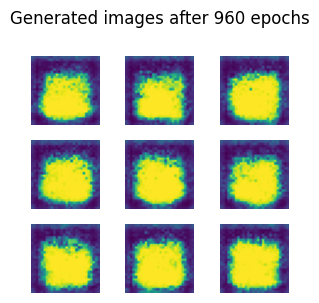

global epoch is 960


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 961


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 962


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 963


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 964


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 965


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 966


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


global epoch is 967


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 968


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 969


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 970


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 971


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 972


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 973


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


global epoch is 974


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


global epoch is 975


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


global epoch is 976


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


global epoch is 977


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 978


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 979


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


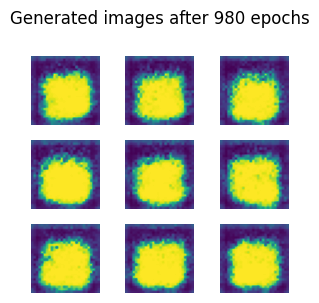

global epoch is 980


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 981


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 982


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


global epoch is 983


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


global epoch is 984


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 985


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


global epoch is 986


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


global epoch is 987


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 988


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


global epoch is 989


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 990


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


global epoch is 991


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


global epoch is 992


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 993


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


global epoch is 994


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


global epoch is 995


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


global epoch is 996


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


global epoch is 997


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


global epoch is 998


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


global epoch is 999


generator training of global epoch 1000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


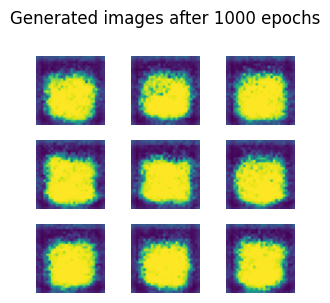

In [15]:
epochs = 1000
generator_epochs = 10
discriminator_epochs = 1
discriminator_loss = []
generator_loss = []
for epoch in range(epochs):
    print(f'global epoch is {epoch}')
    for discriminator_epoch in tqdm(range(discriminator_epochs), desc =f"discriminator training of global epoch {epochs}"):
        train_generator.reset()
        for image_batch,labels in train_generator:
            image_batch = np.reshape(image_batch,(len(image_batch),-1))
            labels = labels.argmax(axis=1).reshape((-1,1))
            
            noise= np.random.normal(-10,10, [len(image_batch), 16*16-2])
            noise_class = np.random.randint(0,2,[len(image_batch),1])
            
            noise_class_one_hot = np.zeros((noise_class.size, 2))
            noise_class_one_hot[np.arange(noise_class.size), noise_class] = 1
            input_nois = np.hstack([noise,noise_class_one_hot])
                        
            generated_images = g.predict(input_nois,verbose=0)
            X= np.concatenate([image_batch, generated_images])
            
            y_dis=np.zeros((2*len(image_batch),1))
            y_dis[:len(image_batch)]=1
            y_class = np.concatenate([labels,noise_class])
            
            Y = np.hstack([y_dis,y_class])
            
            d.trainable=True
            loss = d.train_on_batch(X, y_dis)
            discriminator_loss.append(loss)
            if batch_size > len(image_batch) :break
            
    for generator_epoch in tqdm(range(generator_epochs), desc =f"generator training of global epoch {epochs}"):
        #Tricking the noised input of the Generator as real data
        batch_size = 256
        noise= np.random.normal(0,1, [batch_size, 16*16-2])
        noise_class = np.random.randint(0,2,[batch_size,1])
        noise_class_one_hot = np.zeros((batch_size, 2))
        noise_class_one_hot[np.arange(batch_size), noise_class] = 1
        input_nois = np.hstack([noise,noise_class_one_hot])
        y_dis=np.zeros((batch_size,1))
        Y = np.hstack([y_dis,noise_class])
        # During the training of gan, 
        # the weights of discriminator should be fixed. 
        #We can enforce that by setting the trainable flag
        d.trainable=False
        #training  the GAN by alternating the training of the Discriminator 
        #and training the chained GAN model with Discriminator’s weights freezed.
        loss = gan.train_on_batch(input_nois, y_dis)
        generator_loss.append(loss)
    #For every 50 epochs, we plot the generated images
    if ((epoch+1) % 20) == 0:
        plot_generated_images(epoch+1, g)


In [16]:
discriminator_loss  =np.mean(np.reshape(discriminator_loss,(discriminator_epochs*epochs,-1)),axis=1)

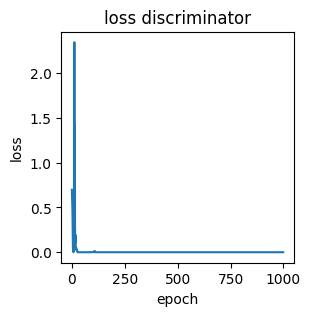

In [17]:
plt.figure(figsize=(3,3))
discriminator_loss  =np.mean(np.reshape(discriminator_loss,(discriminator_epochs*epochs,-1)),axis=1)
plt.plot(range(len(discriminator_loss)),discriminator_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss discriminator')
plt.savefig("loss discriminator.png")
plt.show()


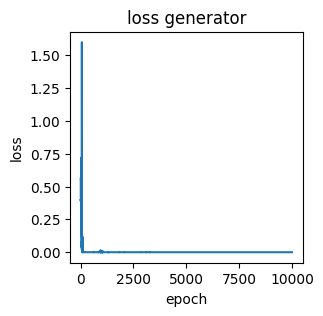

In [18]:
plt.figure(figsize=(3,3))
plt.plot(range(len(generator_loss)),generator_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss generator')
plt.savefig("loss generator.png")
plt.show()


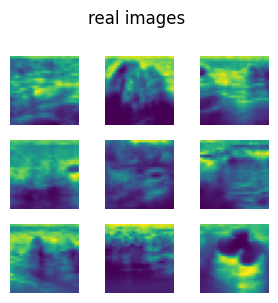

In [19]:
real_image = next(train_generator)[0][:9]
real_image = np.asarray(real_image*255,dtype=np.uint8)
plt.figure(figsize=(3,3))
for i in range(real_image.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(real_image[i])
    plt.axis('off')
plt.suptitle('real images ' ,y=0.995)
plt.tight_layout()    
plt.show()


# resnet model for generated image

In [20]:
gen_resnet_model = Sequential()
gen_resnet_model.add(resnet50_base_model)
gen_resnet_model.add(layers.Dense(1000,activation = 'relu'))
gen_resnet_model.add(layers.Dense(2,activation = 'softmax'))
gen_resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 1000)              2049000   
                                                                 
 dense_5 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 25,638,714
Trainable params: 2,051,002
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
batch_size = 4000
noise= np.random.normal(0,1, [batch_size, 16*16-2])
noise_class = np.vstack([np.zeros((batch_size//2,1),dtype=np.int),np.ones((batch_size//2,1),dtype=np.int)])
noise_class_one_hot = np.zeros((batch_size, 2))
noise_class_one_hot[np.arange(batch_size), noise_class] = 1
input_nois = np.hstack([noise,noise_class_one_hot])
generated_images = g.predict(input_nois,verbose=0)
generated_images = generated_images.reshape((-1,28,28,1))


/var/folders/wh/xkgkz2s94qv9j7mhyld__r000000gn/T/ipykernel_9664/861004320.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  noise_class = np.vstack([np.zeros((batch_size//2,1),dtype=np.int),np.ones((batch_size//2,1),dtype=np.int)])


In [22]:
image_data = []
labels_data = []
train_generator.reset()
for image_batch,labels in train_generator:
    image_data.append(image_batch)
    labels_data.append(labels)
    if len(image_batch)<256:
        break

image_data = np.concatenate(image_data)
labels_data = np.concatenate(labels_data)


In [23]:
image_with_gen = np.vstack([image_data,generated_images])
image_with_gen = np.repeat(image_with_gen, 3, axis=3)
labels_with_gen = np.vstack([labels_data,noise_class_one_hot])

In [24]:
resnet_model.compile(optimizer=optimizers.legacy.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = resnet_model.fit(preprocess_input(image_with_gen),labels_with_gen,epochs=10,validation_data=valid_generator)


Epoch 1/10
143/143 [==============================] - 7s 34ms/step - loss: 1.3905 - accuracy: 0.8383 - val_loss: 1.1670 - val_accuracy: 0.2692
Epoch 2/10
143/143 [==============================] - 3s 24ms/step - loss: 1.5204 - accuracy: 0.9122 - val_loss: 1.0030 - val_accuracy: 0.2692
Epoch 3/10
143/143 [==============================] - 4s 25ms/step - loss: 1.5397 - accuracy: 0.9138 - val_loss: 0.8699 - val_accuracy: 0.2692
Epoch 4/10
143/143 [==============================] - 4s 25ms/step - loss: 1.5308 - accuracy: 0.9206 - val_loss: 0.7504 - val_accuracy: 0.2821
Epoch 5/10
143/143 [==============================] - 4s 25ms/step - loss: 1.5277 - accuracy: 0.9276 - val_loss: 0.6697 - val_accuracy: 0.6795
Epoch 6/10
143/143 [==============================] - 4s 25ms/step - loss: 1.5096 - accuracy: 0.9289 - val_loss: 0.6007 - val_accuracy: 0.7308
Epoch 7/10
143/143 [==============================] - 3s 24ms/step - loss: 1.4979 - accuracy: 0.9382 - val_loss: 0.5841 - val_accuracy: 0.7308

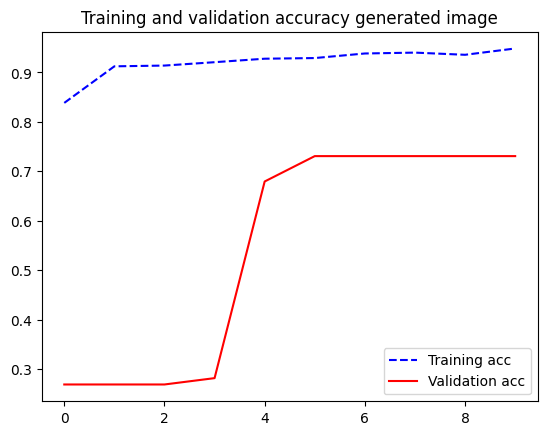

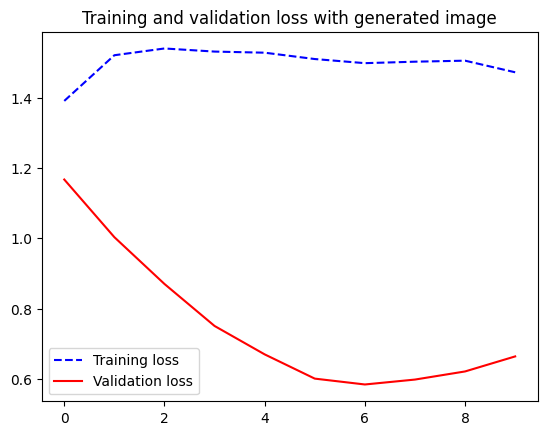

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy generated image')
plt.legend()
plt.savefig("loss_gen.png")
plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss with generated image')
plt.legend()
plt.savefig("acc_gen.png")

In [26]:
from sklearn.metrics import confusion_matrix,classification_report

y_pred = resnet_model.predict(test_generator)
y_pred = y_pred.argmax(axis=1)
print("confusion_matrix\n",confusion_matrix(test_generator.labels,y_pred))
print(classification_report(test_generator.labels,y_pred))

1/1 [==============================] - 1s 961ms/step
confusion_matrix
 [[  0  42]
 [  0 114]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.73      1.00      0.84       114

    accuracy                           0.73       156
   macro avg       0.37      0.50      0.42       156
weighted avg       0.53      0.73      0.62       156

